# Sentiment Analysis on Tweets using bag of words and TF-IDF

Natural Language Processing (NLP) is a one of my favorite areas in data science and one of the most common applications of NLP is sentiment analysis. In this notebook I will detect sentiment analysis on Twitter. I'm going to divide the process in the following steps:


- Preprocessing ad cleaning the text
- Explore the cleaned data to get insights
- Extract numerical features from the data
- Use these feature sets to train our model and identify the sentiments of the tweets

# Tweets Preprocessing and Cleaning

Let’s first load our data and the necessary libraries:

In [0]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [0]:
train  = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

Let’s check the first few rows of the train dataset:

In [0]:
train.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


The data has 3 columns id, label, and tweet. label is the binary target variable and tweet contains the tweets that we will clean and preprocess. 

# Removing Twitter Handles (@user)

As mentioned above, the tweets contain lots of twitter handles (@user), that is how a Twitter user acknowledged on Twitter. We will remove all these twitter handles from the data as they don’t convey much information.

For our convenience, let’s first combine train and test set. This saves the trouble of performing the same steps twice on test and train.

In [0]:
combi = train.append(test, ignore_index=True)

Given below is a user-defined function to remove unwanted text patterns from the tweets. It takes two arguments, one is the original string of text and the other is the pattern of text that we want to remove from the string. The function returns the same input string but without the given pattern. We will use this function to remove the pattern ‘@user’ from all the tweets in our data.

In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

Now let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets. Note that we have passed “@[\w]*” as the pattern to the remove_pattern function. It is actually a regular expression which will pick any word starting with ‘@

In [0]:
# remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

# Removing Punctuations, Numbers, and Special Characters

As discussed, punctuations, numbers and special characters do not help much. It is better to remove them from the text just as we removed the twitter handles. Here we will replace everything except characters and hashtags with spaces.

In [0]:
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

# Removing Short Words

We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [0]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

Let’s take another look at the first few rows of the combined dataframe:

In [0]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


You can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

# Tokenization

Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [0]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

# Stemming

Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.

In [0]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, cau, they, offer, wheel...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

Now let’s stitch these tokens back together:

In [0]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

# Story Generation and Visualization from Tweets

Now, we will explore the cleaned tweets, responding the following question:


    - What are the most common words in the entire dataset?
    - What are the most common words in the dataset for negative and positive tweets, respectively?
    - How many hashtags are there in a tweet?
    - Which trends are associated with my dataset?
    - Which trends are associated with either of the sentiments? Are they compatible with the sentiments?


# Understanding the common words used in the tweets: WordCloud

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A **wordcloud** is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot:

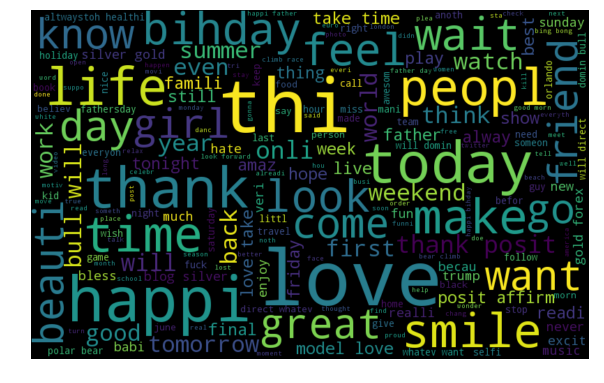

In [0]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy and love being the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes(racist/sexist or not) in our train data.

# Words in non racist/sexist tweets

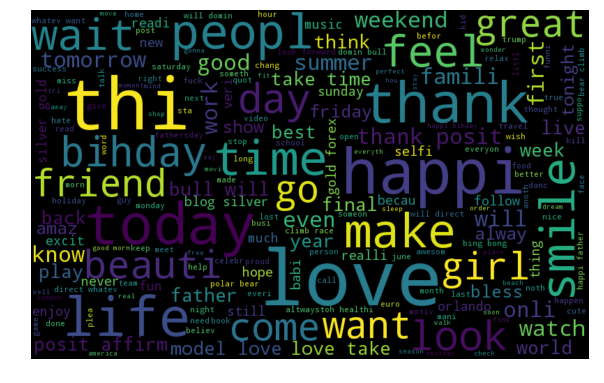

In [0]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy, smile, and love being the most frequent ones. Hence, most of the frequent words are compatible with the sentiment which is non racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

# Racist/Sexist Tweets

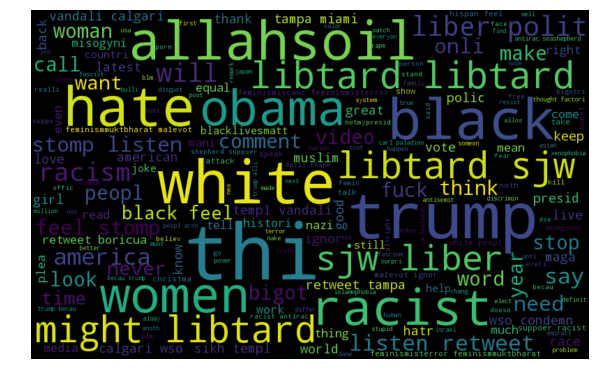

In [0]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

# Understanding the impact of Hashtags on tweets sentiment

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments. 

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets:

In [0]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top n hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

**Non-Racist/Sexist Tweets**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


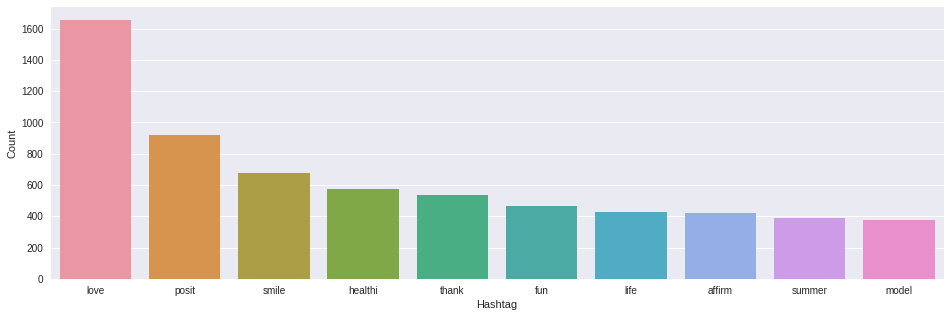

In [0]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

**Racist/Sexist Tweets**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


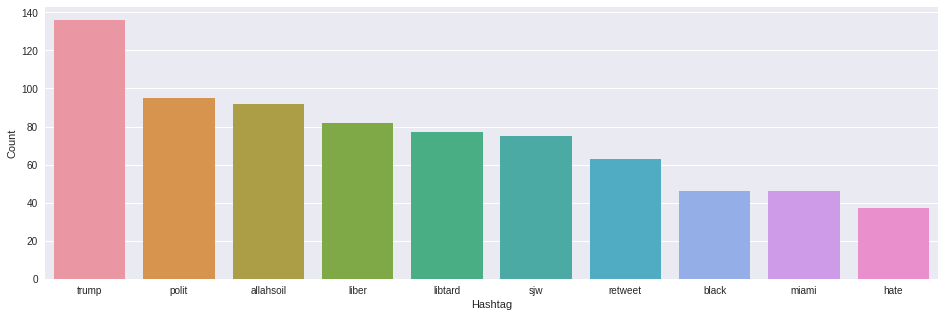

In [0]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

# Extracting Features from Cleaned Tweets

Bag-of-Words is a method to represent text into numerical features. Let us understand this using a simple example. Suppose we have only 2 document:

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The list created would consist of all the unique tokens in the corpus C.

= [‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

Bag-of-Words features can be easily created using sklearn’s CountVectorizer function. We will set the parameter max_features = 1000 to select only top 1000 terms ordered by term frequency across the corpus.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

# TF-IDF Features

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

    TF = (Number of times term t appears in a document)/(Number of terms in the document)
    IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
    TF-IDF = TF*IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

# Model Building: Sentiment Analysis

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. Now we will be building predictive models on the dataset using the two feature set — Bag-of-Words and TF-IDF.

We will use logistic regression to build the models. It predicts the probability of occurrence of an event by fitting data to a logit function.The following equation is used in Logistic Regression


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/07/log_equation.png)

# Building model using Bag-of-Words features

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5293132328308208

**Output:** 0.5293
We trained the logistic regression model on the Bag-of-Words features and it gave us an F1-score of 0.53 for the validation set. Now we will use this model to predict for the test data 

In [0]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

Now we will again train a logistic regression model but this time on the TF-IDF features. Let’s see how it performs.

# Building model using TF-IDF features

In [0]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.545615589016829

**Output:** 0.5456
The validation score is 0.5456 and the public leaderboard F1 score is 0.564. So, by using the TF-IDF features, the validation score has improved and the public leaderboard score is more or less the same.  Now we will use this model to predict for the test data :

In [0]:
test_pred = lreg.predict_proba(test_tfidf )
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_tfidf.csv', index=False) # writing data to a CSV file